In [1]:
# 挂载 google 云盘
from google.colab import drive
drive.mount('/content/gdrive')

# 将文件路径指定为数据路径
import os
os.chdir('/content/gdrive/My Drive/comment')

# 第一次使用该语句可下载词向量数据集压缩包，其后可忽略，
# !wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
# 解压缩
# !unzip 'wiki-news-300d-1M.vec.zip'

# 导入必要的库

# 计算库
import numpy as np
import pandas as pd

from tqdm import tqdm #显示运行进度条
import io

# 画图库
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
import matplotlib.pyplot as plt

# 文字处理库
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
nltk.download('stopwords') #下载停止词
import string
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence

# 深度学习库
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, Dense, SpatialDropout1D, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D
from keras import optimizers, metrics, Model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
# from keras.layers import LSTM,Bidirectional, GRU
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Concatenate, Input, Bidirectional

# 随机种子
import random
random.seed(0)

import pickle

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                63936     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
batch_normalization_4 (Batch (None, 6)                 24        
__________

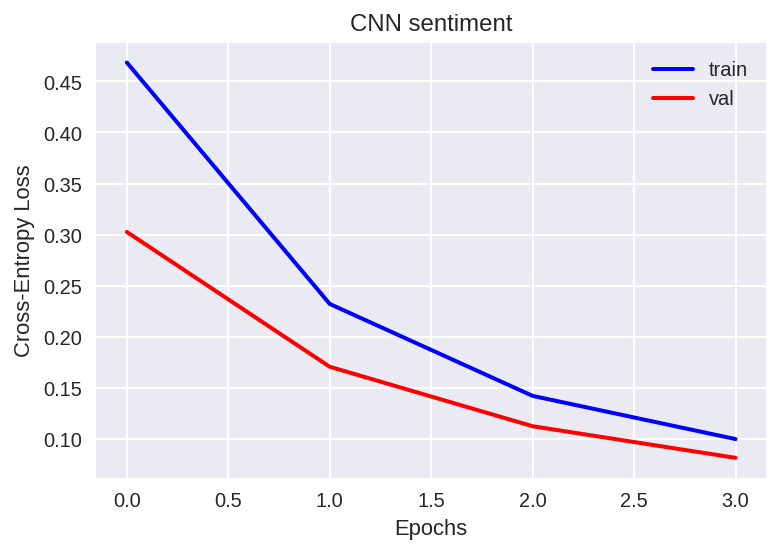

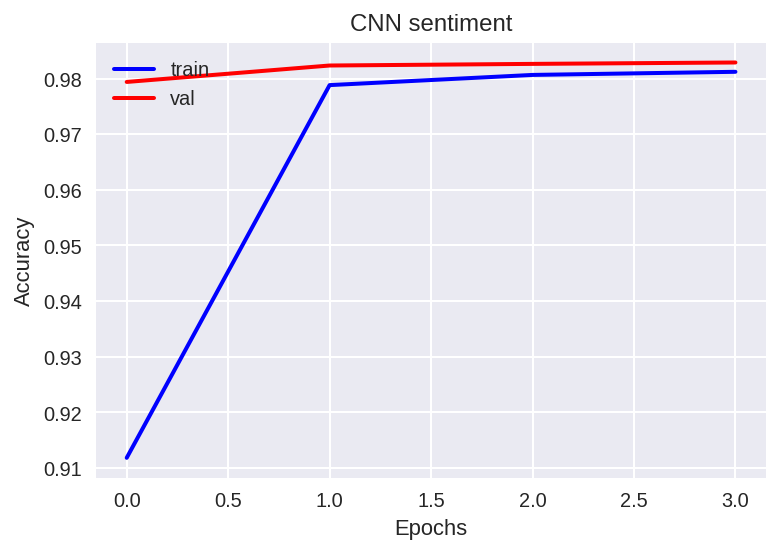

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
var = pickle.load(open('/content/gdrive/My Drive/comment/var.txt', 'rb'))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
word_upper = 50000
word_features = 300
maxlen = 100
seq_train = var['strain']
seq_test = var['stest']
feature_matrix = var['fm']

model = Sequential()
model.add(Embedding(word_upper, 
                    word_features,
                    input_length = maxlen,
                    weights=[feature_matrix],
                    trainable=False))
model.add(SpatialDropout1D(0.5))
model.add(Bidirectional(GRU(32, 
         activation='tanh', 
         recurrent_activation='hard_sigmoid', 
         use_bias=True, 
         kernel_initializer='glorot_uniform', 
         recurrent_initializer='orthogonal', 
         bias_initializer='zeros', 
         kernel_regularizer=None, 
         recurrent_regularizer=None, 
         bias_regularizer=None, 
         activity_regularizer=None, 
         kernel_constraint=None, 
         recurrent_constraint=None, 
         bias_constraint=None, 
         dropout=0, 
         recurrent_dropout=0, 
         implementation=1, 
         return_sequences=False, 
         return_state=False, 
         go_backwards=False, 
         stateful=False, 
         unroll=False, 
         reset_after=False)))
model.add(BatchNormalization())
model.add(LeakyReLU())

# model.add(Dense(32, kernel_initializer='normal'))
# model.add(BatchNormalization())
# model.add(LeakyReLU())

model.add(Dense(len(labels), kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

callbacks = [EarlyStopping(monitor='val_loss', 
                          min_delta=0.01, 
                          patience=3, 
                          verbose=1)] 

batch_size = 128
epochs = 10

X_train, X_valid, Y_train, Y_valid = train_test_split(seq_train, 
                                                      train_data[labels].values, 
                                                      test_size = 0.1,
                                                      shuffle=True
#                                                       random_state = 0
                                                     )

hist = model.fit(X_train, Y_train,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                validation_data=(X_valid, Y_valid),
                shuffle=True,
                verbose=1)



plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

y_test = model.predict(seq_test)
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = test_data['id'].values 
submission_df[label_names] = y_test 
submission_df.to_csv("./GRU.csv", index=False)